In [68]:
import face_recognition
from skimage.transform import resize
from PIL import Image, ImageDraw
import numpy as np
import cv2
from ISR.models import RRDN
from skimage.io import imsave

In [87]:
def land_mask(img, face_landmarks):
    pil_image = Image.fromarray(img)
    d = ImageDraw.Draw(pil_image, 'RGBA')
    
    # Make the eyebrows into a nightmare
    d.polygon(face_landmarks['left_eyebrow'], fill="#ffffff")
    d.polygon(face_landmarks['right_eyebrow'], fill="#ffffff")
    d.line(face_landmarks['left_eyebrow'], fill="#ffffff", width=8)
    d.line(face_landmarks['right_eyebrow'], fill="#ffffff", width=8)

    # Gloss the lips
    d.polygon(face_landmarks['top_lip'], fill="#ffffff")
    d.polygon(face_landmarks['bottom_lip'], fill="#ffffff")
    d.line(face_landmarks['top_lip'], fill="#ffffff", width=8)
    d.line(face_landmarks['bottom_lip'], fill="#ffffff", width=8)

    # Sparkle the eyes
    d.polygon(face_landmarks['left_eye'], fill="#ffffff")
    d.polygon(face_landmarks['right_eye'], fill="#ffffff")

    # Apply some eyeliner
    d.line(face_landmarks['left_eye'] + [face_landmarks['left_eye'][0]], fill="#ffffff", width=8)
    d.line(face_landmarks['right_eye'] + [face_landmarks['right_eye'][0]], fill="#ffffff", width=8)

#     d.line(face_landmarks['chin'], fill="#ffffff", width=8)

    open_cv_image = np.array(pil_image) 
    # Convert RGB to BGR 
#     open_cv_image = open_cv_image[:, :, ::-1].copy() 
#     gray_img=cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)
    mask = cv2.dilate(open_cv_image, np.ones((8,8), np.uint8), iterations=1)
    mask = cv2.GaussianBlur(mask, (7,7), 0)
    return mask

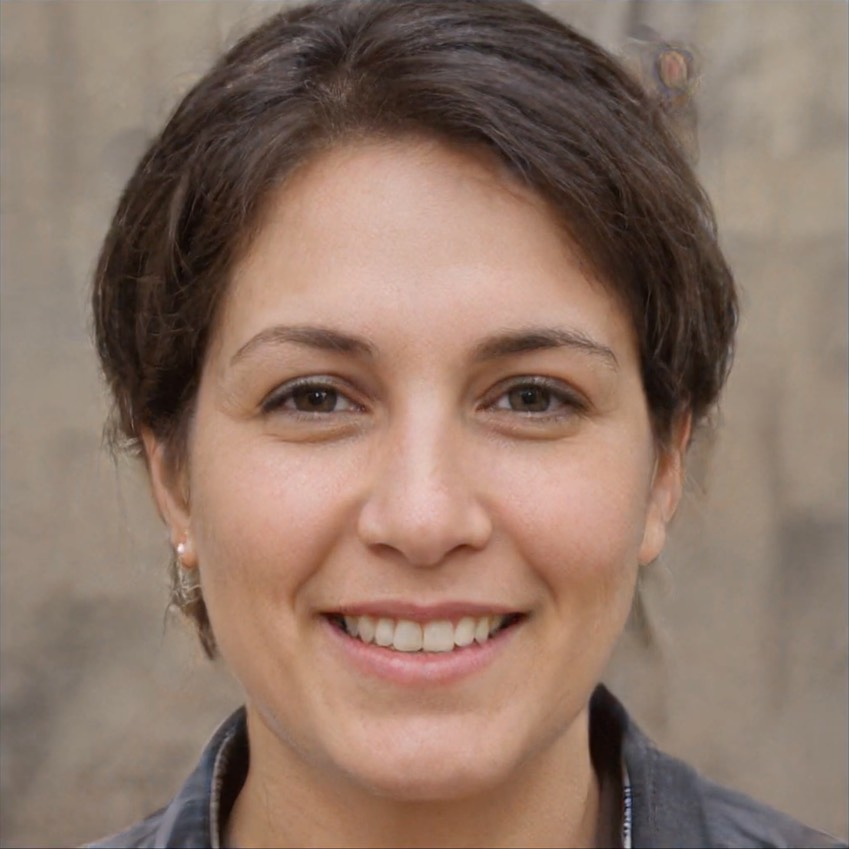

In [88]:
file_name = '4.jpg'
image = face_recognition.load_image_file("test/musk_input/"+file_name)
Image.fromarray(image)

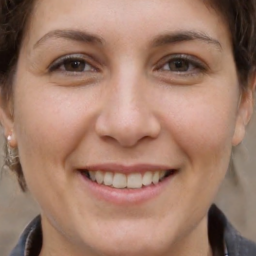

In [89]:
face_locations = face_recognition.face_locations(image)
top, right, bottom, left = face_locations[0]
        
t_width = np.array(image).shape[1]
t_height = np.array(image).shape[0]

top = top - 32 if top - 32 > 0 else 0
bottom = bottom + 32 if bottom + 32 < t_height else t_height-1
left = left - 32 if left - 32 > 0 else 0
right = right + 32 if right + 32 < t_width else t_width-1

width = right - left
height = bottom - top

cropped = image[top:bottom, left:right]
resized_cropped = resize(cropped, (256,256))

Image.fromarray((resized_cropped * 255).astype(np.uint8))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


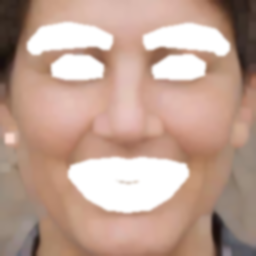

In [90]:
imsave("test/musk_input/tmp.jpg", resized_cropped)
img = face_recognition.load_image_file("test/musk_input/tmp.jpg")
face_landmarks_list = face_recognition.face_landmarks(img)
musk = land_mask(img, face_landmarks_list[0])
Image.fromarray(np.array(musk))

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


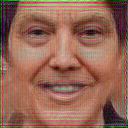

In [67]:
resized_cropped = resize(musk, (128,128))
imsave("test/musk_output/tmp.jpg", resized_cropped)
img = Image.open("test/musk_output/tmp.jpg")
img = img.convert("RGB")
lr_img = np.array(img)
rrdn = RRDN(arch_params={'C':4, 'D':3, 'G':64, 'G0':64,'T':10,'x':1})
rrdn.model.load_weights('trained_weights/2020-07-19_22-32/rrdn-C4-D3-G64-G064-T10-x1_best-val_generator_PSNR_Y_epoch050.hdf5')
sr_img = rrdn.predict(lr_img)
Image.fromarray(sr_img)